In [1]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

In [2]:
# Menampilkan Sampel Data Dan Melakukan Drop Column Tertarik
df = pd.read_csv('../Dataset/kendaraan_train_pca_clean.csv')
df.sample(5)

,Component_1,Component_2,Tertarik
112841,0.141045,-0.878139,0
183382,-2.324607,0.351695,0
203021,1.601837,-0.613816,1
243034,0.995821,-0.924337,0
143392,-0.264203,1.557709,0


In [3]:
# Mengecek Data Kosong
df.isna().sum()

Component_1    0
Component_2    0
Tertarik       0
dtype: int64

## **Feature Selection**

In [4]:
df = df[['Component_1', 'Component_2']]
df.head()

,Component_1,Component_2
0,-2.162936,0.330564
1,3.149257,0.300974
2,-2.283908,0.267602
3,0.633128,0.129323
4,2.348830,0.616102


In [5]:
# Mengecek Total Data Pada Dataframe
print("Total Data :", len(df))

Total Data : 285662


## **K-MEANS Algorithm**

In [6]:
# Mendefinisikan Metode Euclidean Untuk Perhitungan Jarak Dari Centroid
def euclidean(x, y):
    return math.sqrt(sum((x - y)**2))


def kmeans(k, max_iter, df):
    # Inisialisasi Dictionary Centroid Kemudian Memilih Centroid Secara Random Pada Data
    # Sesuai Banyaknya Cluster Yang Didefinisikan
    centroid = {i: df[random.randint(0, len(df))] for i in range(k)}
    print(
        f'Inisialisasi Centroid Random:\nCluster 0: {centroid.get(0)}, Cluster 1: {centroid.get(1)}, Cluster 2: {centroid.get(2)} \n')

    # Mengcopy Centroid Saat Ini Untuk Acuan Pemberhentian Proses Iterasi Centroid Maksimal
    temp_centroid = centroid.copy()

    for i in range(max_iter):
        # Mendefinisikan Dictionary Cluster Dan Mengisi Setiap Key
        # Pada Cluster Berisi Array kosong, contoh : {0: [], 1: [], 2: []}
        cluster = {i: [] for i in range(k)}

        # Mencari Nilai Terdekat Pada Data Untuk Setiap Centroid Yang Telah Di Definisikan Sebelumnya
        # Menggunakan Metode Euclidean Dan Mencari Nilai Minimum Pada Setiap Distance
        # Untuk Dimasukkan Kedalam Dictionary Cluster
        for x in df:
            dist = [euclidean(x, centroid[c]) for c in centroid]
            cluster[dist.index(min(dist))].append(x)

        # Mencari Nilai Centroid Ulang Dari Setiap Cluster
        # Yang Telah Dicari Sebelumnya Menggunakan Mean
        for cl in cluster:
            centroid[cl] = np.mean(cluster[cl], axis=0)

        print(
            f'Iterasi Centroid Ke-{i+1}:\nCluster 0: {centroid.get(0)}, Cluster 1: {centroid.get(1)}, Cluster 2: {centroid.get(2)} \n')

        # Pemberhentian Proses Iterasi Ketika Centroid Saat Ini Sama Dengan Nilai Centroid Sebelumnya
        # Dilakukan Dengan Pengecekan Masing-Masing Value Dari Dictionary
        if ((temp_centroid.get(0) == centroid.get(0))[0] and
            (temp_centroid.get(1) == centroid.get(1))[0] and
            (temp_centroid.get(2) == centroid.get(2))[0] and
            (temp_centroid.get(3) == centroid.get(3))[0]):
            break

        # Mengcopy Centroid Yang Telah Berubah Dari Perhitungan Sebelumnya
        temp_centroid = centroid.copy()

    # Mengembalikan Nilai Dari Variabel Centroid Dan Cluster
    return centroid, cluster

## **Main Program**

In [7]:
# Merubah DataFrame Menjadi Numpy Array
data = df.to_numpy()

# Memasukkan Nilai K dan Maksimum Iterasi
k = 4
max_iter = 100

# Memanggil Fungsi kmeans Yang Akan Mengembalikan Nilai Centroid Dan Cluster
centroid, cluster = kmeans(k, max_iter, data)

Inisialisasi Centroid Random:
Cluster 0: [0.84294928 0.65289393], Cluster 1: [0.52022811 2.27977376], Cluster 2: [-0.52129972  0.98075203] 

Iterasi Centroid Ke-1:
Cluster 0: [ 1.43790728 -0.43924441], Cluster 1: [0.64863333 2.24750442], Cluster 2: [-0.53094693  1.03369236] 

Iterasi Centroid Ke-2:
Cluster 0: [ 1.55646168 -0.46886928], Cluster 1: [0.79097766 2.10783317], Cluster 2: [-0.49610585  1.04516704] 

Iterasi Centroid Ke-3:
Cluster 0: [ 1.61738716 -0.4582753 ], Cluster 1: [0.83309155 2.06378964], Cluster 2: [-0.472297   1.0319124] 

Iterasi Centroid Ke-4:
Cluster 0: [ 1.63772896 -0.45337895], Cluster 1: [0.84175744 2.05556425], Cluster 2: [-0.46243455  1.02497724] 

Iterasi Centroid Ke-5:
Cluster 0: [ 1.64321559 -0.45219921], Cluster 1: [0.84265271 2.05499829], Cluster 2: [-0.45766699  1.02192175] 

Iterasi Centroid Ke-6:
Cluster 0: [ 1.64489804 -0.45167816], Cluster 1: [0.84245184 2.05525433], Cluster 2: [-0.45516533  1.02091605] 

Iterasi Centroid Ke-7:
Cluster 0: [ 1.6453559

## **Hasil Proses Cluster Final**

In [8]:
# Inisialisasi Array Untuk Dat Cluster
df = []

# Melakukan Perulangan Untuk Setiap Key Pada Data
# Hasil Proses K-Means Untuk Diinputkan Kedalam Array Cluster (df)
for key in cluster.keys():
    for c in cluster.get(key):
        df.append((c[0], c[1], key))

# Set Array df menjadi dataframe, Menamakan nama kolom dan menampilkannya
df = pd.DataFrame(df)
df.columns = ['Component_1', 'Component_2', 'Cluster']
df.sample(10)

,Component_1,Component_2,Cluster
72463,1.487695,-0.306563,0
1723,1.590258,0.619743,0
261758,-2.018644,0.509687,3
32276,0.716496,-1.354769,0
274047,-0.369229,-2.072452,3
50140,1.472747,-0.991754,0
260270,-2.455983,0.113647,3
180755,-1.906705,-0.427604,3
92992,1.660619,-0.875858,0
219964,-1.891891,-0.296354,3


In [9]:
# Menampilkan Letak Seluruh Centroids
for i in range(k):
    print(f'Centroid {i+1} :', centroid[i])

Centroid 1 : [ 1.64554251 -0.45164568]
Centroid 2 : [0.84409715 2.05734262]
Centroid 3 : [-0.44924517  1.02191905]
Centroid 4 : [-1.64488532 -0.37262449]


In [10]:
# Memetakkan Nilai X Dan Y Untuk Setiap Data Pada Dictionary Cluster
clusterize = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in cluster.items()]))

# Membuat Nama Kolom Cluster Berdasarkan Jumlah Cluster Pada Clusterize
col = []
for i in range(len(clusterize.columns)):
    col.append('Cluster ' + str(i + 1))

# Melakukan Set Nama Kolom Dan Menampilkan Sample Data Cluster
clusterize.columns = col
clusterize.sample(8)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4
104979,"[2.356558657840567, 0.3194549739366731]",NaN,NaN,"[-0.1170264733375614, -1.5978001439381948]"
198,"[2.1110889967105235, -0.0807736779471041]","[1.1901454413258, 2.984040667771902]","[-0.894303647484385, 0.7810751352024815]","[-0.2891162291062236, -0.6168908233492336]"
42653,"[1.2711373409197455, -0.8684327840739587]",NaN,NaN,"[-2.122352254310125, 0.2552558470903325]"
24438,"[0.8698244103290118, -1.4931644237687085]","[3.783061650326351, 1.976046833454599]","[-0.205195884505853, 1.750217498325697]","[-0.6967097714131416, -1.9311159637878756]"
53390,"[3.650099380919155, 0.7983912430473223]",NaN,NaN,"[-2.2276049778648463, 0.288848987190788]"
72105,"[0.9151608211823692, -0.9793818837175672]",NaN,NaN,"[-2.1776089788911874, 0.309463609952006]"
9807,"[3.708198970376483, 1.092913117132808]","[1.734549298272059, 1.3332621993761284]","[-1.3919862315805114, 0.6379884092500558]","[-1.9889721509608849, 0.1911770712545405]"
84370,"[2.719764602327013, -0.0563385975245515]",NaN,NaN,"[-2.225720717645036, 0.3351474120299211]"


## **Visualisasi Cluster**

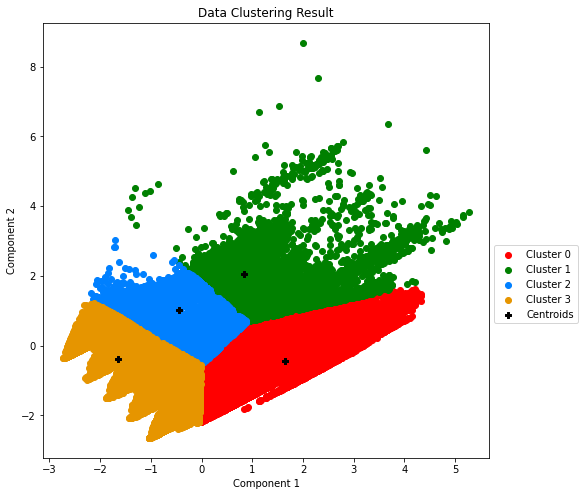

In [11]:
# Set Warna Setiap CLuster
colors = ['r', 'g', '#0080ff', '#e69500', '#e89500']

# Set Ukuran Dan Judul Plot
plt.figure(figsize=(8, 8))
plt.title('Data Clustering Result')

# Melakukan Looping Setiap Titik Data Dan Centroid
for i in range(k):
    plt.scatter(
        df['Component_1'][df['Cluster'] == i], 
        df['Component_2'][df['Cluster'] == i],
        color=colors[i],
        label=f'Cluster {i}'
    )

    plt.scatter(centroid[i][0], centroid[i][1], color='k', marker='P')

# Acuan Penampilan Label Centroid
plt.scatter(centroid[0][0], centroid[0][1], color='k', label="Centroids", marker='P')

# Set Nama Label X Dan Y Pada Plot Dan Set Tempat Legend Ditampilkan
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.show()


## **Evaluasi Model**

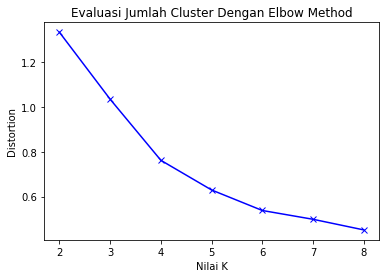

In [12]:
# Inisialisasi Array Untuk Distortion
distortions = []

# Inisialisasi Range K
K = range(2, 9)

# Melakukan Perulangan Untuk Setiap Range
for i in K:
    # Membangun Dan Fit Dataset
    model = KMeans(n_clusters=i).fit(df)
    model.fit(df)

    # Memasukkan Hasil Dari Jumlah cdist data, cluster_center Ke Array
    distortions.append(sum(np.min(cdist(df, model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

# Plot data
plt.plot(K, distortions, 'bx-')
plt.xlabel('Nilai K')
plt.ylabel('Distortion')
plt.title('Evaluasi Jumlah Cluster Dengan Elbow Method')
plt.show()